### SeaFlow data (regridded)

In [1]:
using NetCDF, StanSample, PyPlot, Statistics, PyCall, Interpolations

┌ Info: Precompiling StanSample [c1514b29-d3a0-5178-b312-660c88baa699]
└ @ Base loading.jl:1273


In [2]:
### load data
data_seaflow = Dict("time" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","time",start=[1],count=[-1]),
                    "size_bounds" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","size_bounds",start=[1],count=[-1]),
                    "w_obs" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","w_obs",start=[1,1],count=[-1,-1]),
                    "PAR" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","PAR",start=[1],count=[-1]),
                    "m" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","m")[1],
                    "v_min" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","v_min")[1],
                    "delta_v_inv" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","delta_v_inv")[1])

Dict{String,Any} with 7 entries:
  "size_bounds" => [0.0135, 0.0155074, 0.0178134, 0.0204622, 0.0235049, 0.027, …
  "time"        => [0, 3, 6, 9, 12, 15, 18, 21, 24, 27  …  5729, 5732, 5735, 57…
  "w_obs"       => [0.018937 0.0755286 … 0.000536307 0.000130877; 0.0188122 0.0…
  "PAR"         => [1987.91, 2137.93, 1981.03, 1967.0, 2041.37, 2054.12, 2030.1…
  "m"           => 15
  "v_min"       => 0.0135
  "delta_v_inv" => 5

In [3]:
v_min = data_seaflow["v_min"]
delta_v = 1.0/data_seaflow["delta_v_inv"]
v = v_min .* 2 .^(collect(0:1:data_seaflow["m"]-1)*delta_v);

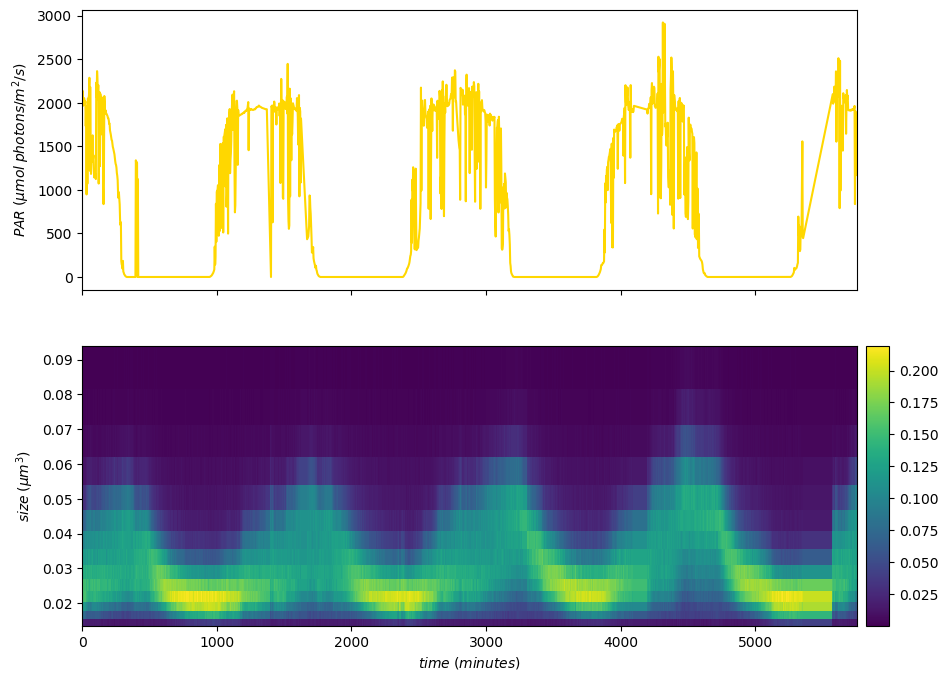

In [50]:
inset_locator = pyimport("mpl_toolkits.axes_grid1.inset_locator")
fig,axs = plt.subplots(nrows=2, sharex=true, figsize=(10,8))
axs[1].plot(data_seaflow["time"], data_seaflow["PAR"], color="gold")
axs[1].set(ylabel=L"PAR\;(\mu mol\;photons/m^{2}/s)")
pc = axs[2].pcolormesh(data_seaflow["time"],v,reverse(rotl90(data_seaflow["w_obs"]),dims=1))
axs[2].set(ylabel=L"size\;(\mu m^3)", xlabel=L"time\;(minutes)")
pcb = inset_locator.inset_axes(axs[2], width="3%", height="100%", loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=axs[2].transAxes)
fig.colorbar(pc,cax=pcb, pad = 0.02);

### The model
modified from Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.

In [5]:
stan_code = """data {
    // size variables
    int<lower=0> m;         // number of size classes
    int<lower=0> nt;        // number of timesteps
    int<lower=0> nt_obs;    // number of timesteps with observations
    // model parameters and input
    int<lower=0> dt;        // delta t in minutes
    real<lower=0> E[nt];    // vector of incident radiation values
    real<lower=0> v_min;    // size in smallest size class in um^-3
    int<lower=0> delta_v_inv;   // inverse of delta_v 
    simplex[m] w_ini;       // initial conditions 
    // observations
    real<lower=0,upper=nt*dt>  t_obs[nt_obs]; // the time of each observation
    real<lower=0> obs[m,nt_obs]; // observations
}
transformed data {
    int j;
    real<lower=0> delta_v;
    real<lower=0> dt_days;  // dt in units of days
    real<lower=0> v[m];     // vector of (minimum) sizes for each size class
    int<lower=0> t[nt];     // vector of times in minutes since start 
    int<lower=1, upper=nt> it_obs[nt_obs]; // the time index of each observation

    j = 1 + delta_v_inv; 
    delta_v = 1.0/delta_v_inv;
    dt_days = dt/1440.0;
    for (i in 1:m){
        v[i] = v_min*2^((i-1)*delta_v);
    }
    // populate time vector
    t[1] = 0;
    for (i in 2:nt){
        t[i] = (t[i-1] + dt);
    }
    // populate index vector it_obs
    for (k in 1:nt_obs){
        for (i in 1:nt){
            if (t_obs[k]>=t[i] && t_obs[k]<t[i]+dt){
                it_obs[k] = i;
                break;
            }
        }
    }
}
parameters {
    real<lower=0> b; 
    real<lower=0> delta_max; 
    real<lower=0> gamma_max;
    real<lower=0, upper=5000> E_star; 
    real<lower=1e-10> sigma; 
}
transformed parameters {
    matrix[m,nt_obs] mod_obspos;
    {
        // helper variables
        vector[m] w_curr; 
        vector[m] w_next;
        real delta_i;
        real gamma;
        real a;
        real tmp;
        int ito = 1;
        
        w_curr = w_ini;

        for (it in 1:nt){ // time-stepping loop
            // record current solution 
            if (it == it_obs[ito]){
                mod_obspos[,ito] = w_curr;
                ito += 1;
                if (ito > nt_obs){
                    break;
                }
            }
            // compute gamma
            gamma = gamma_max * dt_days * (1.0 - exp(-E[it]/E_star));

            w_next = rep_vector(0.0, m);
            for (i in 1:m){ // size-class loop
                // compute delta_i
                tmp = v[i]^b; 
                delta_i = delta_max * dt_days * (tmp/(1+tmp));
                
                // fill subdiagonal (growth)
                if (i < j){
                    //A[i+1,i] = gamma;
                    a = gamma;
                    w_next[i+1] += a * w_curr[i];
                } else if (i < m){
                    //A[i+1,i] = gamma * (1.0-delta_i);
                    a = gamma * (1.0-delta_i);
                    w_next[i+1] += a * w_curr[i];
                }
                // fill (j-1)th superdiagonal (division)
                if (i >= j){
                    //A[i+1-j,i] = 2.0*delta_i;
                    a = 2.0*delta_i;
                    w_next[i+1-j] += a * w_curr[i];
                }
                // fill diagonal (stasis)
                if (i < j){
                    //A[i,i] = (1.0-gamma);
                    a = (1.0-gamma);
                    w_next[i] += a * w_curr[i];
                } else if (i == m){
                    //A[i,i] = (1.0-delta_i);
                    a = (1.0-delta_i);
                    w_next[i] += a * w_curr[i];
                } else {
                    //A[i,i] = (1.0-gamma) * (1.0-delta_i);
                    a = (1.0-gamma) * (1.0-delta_i);
                    w_next[i] += a * w_curr[i];
                }
            }
            w_curr = w_next ./ sum(w_next);
        }
    }
}
model {
    real diff;
    
    // priors
    b ~ normal(1.0,0.8);
    delta_max ~ uniform(0.0,1440.0/dt);
    gamma_max ~ uniform(0.0,1440.0/dt);
    E_star ~ normal(3000.0,1000.0);
    sigma ~ exponential(1000.0);

    // fitting observations
    for (it in 1:nt_obs){
        diff = 0.0;
        for (iv in 1:m){
            diff += fabs(mod_obspos[iv,it] - obs[iv,it]);
        }
        diff = diff/sigma;
        diff ~ normal(0.0, 1.0) T[0,];
    }
}
""";

In [6]:
### prepare data for stan model
dt = 20 # in units of minutes
data = Dict("dt" => dt,
            "m" => data_seaflow["m"],
            "v_min" => data_seaflow["v_min"],
            "delta_v_inv" => data_seaflow["delta_v_inv"],
            "obs" => data_seaflow["w_obs"],
            "t_obs" => data_seaflow["time"],
            "E" => data_seaflow["PAR"],
            "w_ini" => data_seaflow["w_obs"][1,:], # use first measurements as initial conditions
            "nt" => 2*1440÷dt,
            "nt_obs" => length(data_seaflow["time"]))

limit_to_numdays = 2.0
stride_t_obs = 20

itp = interpolate((data["t_obs"],), data["E"], Gridded(Linear()));
data["E"] = itp(collect(1:1:data["nt"])*data["dt"])

ind_obs = findall(x -> x>3, data["t_obs"]);
data["t_obs"] = data["t_obs"][ind_obs];
data["obs"] = data["obs"][ind_obs,:];

if limit_to_numdays > 0
    thresh = limit_to_numdays*1440
    ind_obs = findall(x -> x<thresh, data["t_obs"])
    data["t_obs"] = data["t_obs"][ind_obs]
    data["obs"] = data["obs"][ind_obs,:]
    data["nt"] = Int(thresh÷data["dt"])
end

if stride_t_obs > 0
    data["t_obs"] = data["t_obs"][collect(1:stride_t_obs:length(data["t_obs"]))]
    data["obs"] = data["obs"][collect(1:stride_t_obs:size(data["obs"],1)),:];
end
data["nt_obs"] = size(data["t_obs"],1)
data["obs"] = reverse(rotl90(data["obs"]),dims=1);

In [7]:
sm = SampleModel("MatrixModel", stan_code)


/var/folders/pb/sxn625r94w77bfkfp_frz08r0000gn/T/jl_3j0eod/MatrixModel.stan updated.


  name =                    "MatrixModel"
  n_chains =                4
  output =                  Output()
    file =                    ""
    diagnostics_file =        ""
    refresh =                 100
  tmpdir =                  "/var/folders/pb/sxn625r94w77bfkfp_frz08r0000gn/T/jl_3j0eod"
  method =                  Sample()
    num_samples =             1000
    num_warmup =              1000
    save_warmup =             false
    thin =                    1
    algorithm =               HMC()
      engine =                  NUTS()
        max_depth =               10
      metric =                  StanSample.diag_e
      stepsize =                1.0
      stepsize_jitter =         1.0
    adapt =                   Adapt()
      gamma =                   0.05
      delta =                   0.8
      kappa =                   0.75
      t0 =                      10.0
      init_buffer =             75
      term_buffer =             50
      window =                  25


In [8]:
(sample_file, log_file) = stan_sample(sm, data=data, n_chains = 4);

In [9]:
chns = read_samples(sm)

Object of type Chains, with data of type 1000×702×4 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = lp__, accept_stat__, stepsize__, treedepth__, n_leapfrog__, divergent__, energy__
parameters        = b, delta_max, gamma_max, E_star, sigma, mod_obspos.1.1, mod_obspos.2.1, mod_obspos.3.1, mod_obspos.4.1, mod_obspos.5.1, mod_obspos.6.1, mod_obspos.7.1, mod_obspos.8.1, mod_obspos.9.1, mod_obspos.10.1, mod_obspos.11.1, mod_obspos.12.1, mod_obspos.13.1, mod_obspos.14.1, mod_obspos.15.1, mod_obspos.1.2, mod_obspos.2.2, mod_obspos.3.2, mod_obspos.4.2, mod_obspos.5.2, mod_obspos.6.2, mod_obspos.7.2, mod_obspos.8.2, mod_obspos.9.2, mod_obspos.10.2, mod_obspos.11.2, mod_obspos.12.2, mod_obspos.13.2, mod_obspos.14.2, mod_obspos.15.2, mod_obspos.1.3, mod_obspos.2.3, mod_obspos.3.3, mod_obspos.4.3, mod_obspos.5.3, mod_obspos.6.3, mod_obspos.7.3, mod_obspos.8.3, mod_obspos.9.3, mod_obspos.10.3, mod_obspos

In [10]:
ESS = ess(chns)

ESS

│ Row │ parameters       │ ess     │ r_hat    │
│     │ Symbol           │ Any     │ Any      │
├─────┼──────────────────┼─────────┼──────────┤
│ 1   │ b                │ 362.747 │ 1.01209  │
│ 2   │ delta_max        │ 340.533 │ 1.00698  │
│ 3   │ gamma_max        │ 206.197 │ 1.03014  │
│ 4   │ E_star           │ 217.871 │ 1.01873  │
│ 5   │ sigma            │ 513.252 │ 1.01681  │
│ 6   │ mod_obspos.1.1   │ 16.0643 │ 1.46239  │
│ 7   │ mod_obspos.2.1   │ 16.0643 │ 6.48526  │
│ 8   │ mod_obspos.3.1   │ 16.0643 │ 1.46239  │
│ 9   │ mod_obspos.4.1   │ 16.0643 │ Inf      │
│ 10  │ mod_obspos.5.1   │ 16.0643 │ Inf      │
│ 11  │ mod_obspos.6.1   │ 16.0643 │ 4.38716  │
│ 12  │ mod_obspos.7.1   │ 16.0643 │ 1.95308  │
│ 13  │ mod_obspos.8.1   │ 16.0643 │ 0.998999 │
│ 14  │ mod_obspos.9.1   │ NaN     │ NaN      │
│ 15  │ mod_obspos.10.1  │ 16.0643 │ 7.54228  │
│ 16  │ mod_obspos.11.1  │ 16.0643 │ 0.998999 │
│ 17  │ mod_obspos.12.1  │ 16.0643 │ 9.66355  │
│ 18  │ mod_obspos.13.1  │ 16.0643 

In [11]:
rawdata = DataFrame(chns, showall=true, sorted=true, append_chains=true);

In [12]:
using StatsPlots

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273


In [13]:
paramdata = [rawdata.b rawdata.delta_max rawdata.gamma_max rawdata.E_star rawdata.sigma];
paramname = ["b", "delta_max", "gamma_max", "E_star", "sigma"];
StatsPlots.cornerplot(paramdata, compact=true, label = paramname,size=(1000,1000))

In [14]:
res = Dict("model" => reshape(chns.info[1].x[2][1][6:695,2],15,46), "obs" => data["obs"])
diff = res["model"]-res["obs"];
t = collect(1:1:data["nt"])*data["dt"];

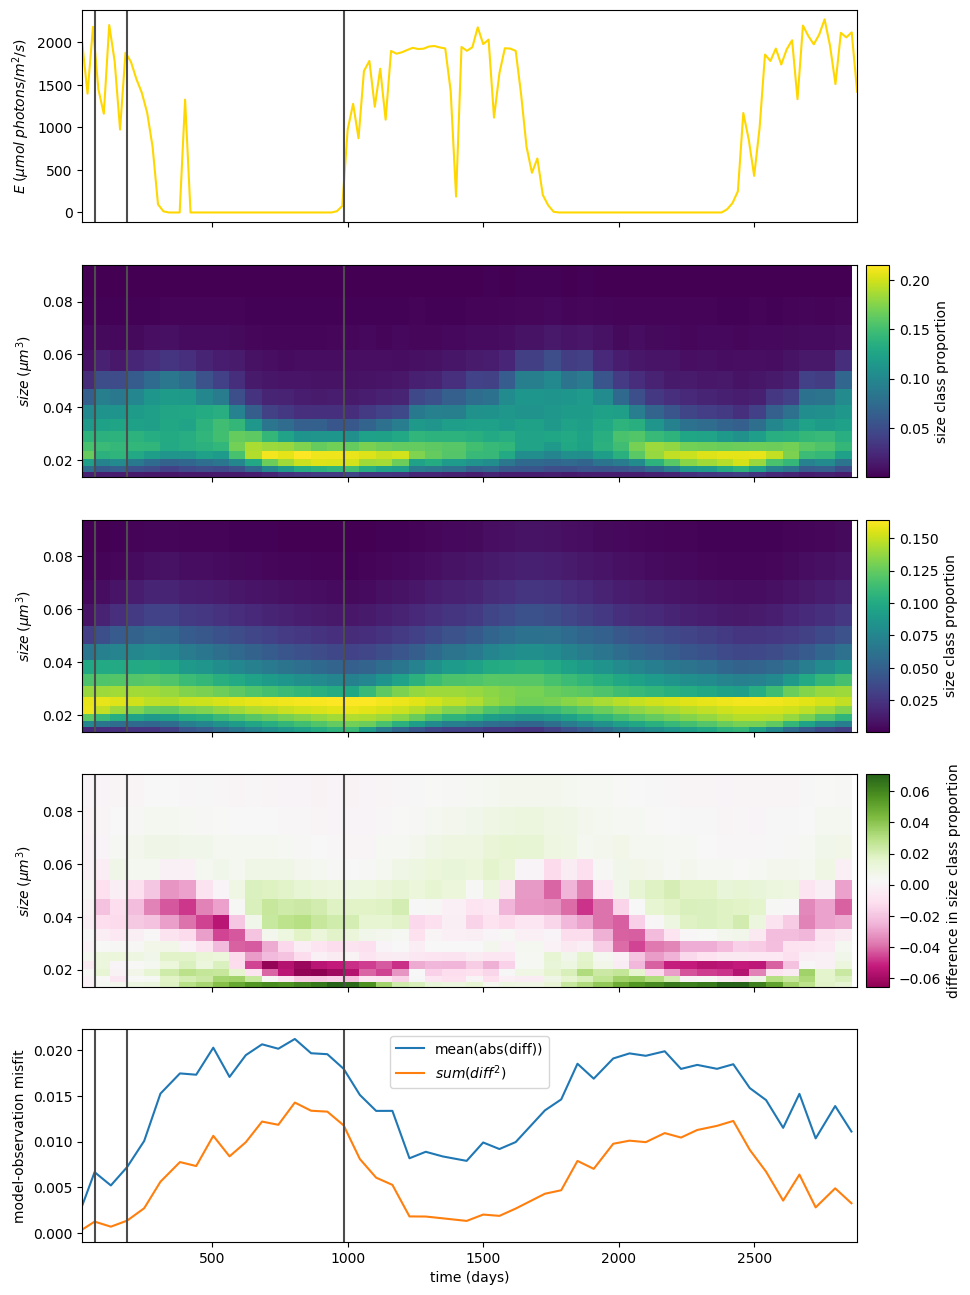

In [37]:
cm = pyimport("matplotlib.cm")
fig,axs = plt.subplots(5,1,sharex=true,figsize=(10,16))
axs[1].plot(t, data["E"], color="gold")
axs[1].set(xlim=(t[1],t[end]), ylabel=L"E\;(\mu mol\;photons/m^{2}/s)")

p2 = axs[2].pcolormesh(data["t_obs"],v,res["obs"])
axs[2].set(ylabel=L"size\;(\mu m^3)")
p2b = inset_locator.inset_axes(axs[2], width="3%", height="100%", loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=axs[2].transAxes)
fig.colorbar(p2,cax=p2b, pad = 0.02,label="size class proportion");

axs[3].set(ylabel=L"size\;(\mu m^3)")
p3 = axs[3].pcolormesh(data["t_obs"],v,res["model"])
p3b = inset_locator.inset_axes(axs[3], width="3%", height="100%", loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=axs[3].transAxes)
fig.colorbar(p3,cax=p3b, pad = 0.02,label="size class proportion");

p4 = axs[4].pcolormesh(data["t_obs"],v,diff,cmap=cm.PiYG)
axs[4].set(ylabel=L"size\;(\mu m^3)")
p4b = inset_locator.inset_axes(axs[4], width="3%", height="100%", loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=axs[4].transAxes)
fig.colorbar(p4,cax=p4b, pad = 0.02,label="difference in size class proportion");

prop = mean(abs.(diff),dims=1)[1,:]
axs[5].plot(data["t_obs"], prop, label="mean(abs(diff))")
prop = sum(diff.^2,dims=1)[1,:]
axs[5].plot(data["t_obs"], prop, label=L"sum(diff^2)")
axs[5].set(xlabel="time (minutes)", ylabel="model-observation misfit")
axs[5].legend();

slice_indices = [1,3,16].+1
for ax in axs
    for i in slice_indices
        ax.axvline(data["t_obs"][i], color=".3")
    end
end

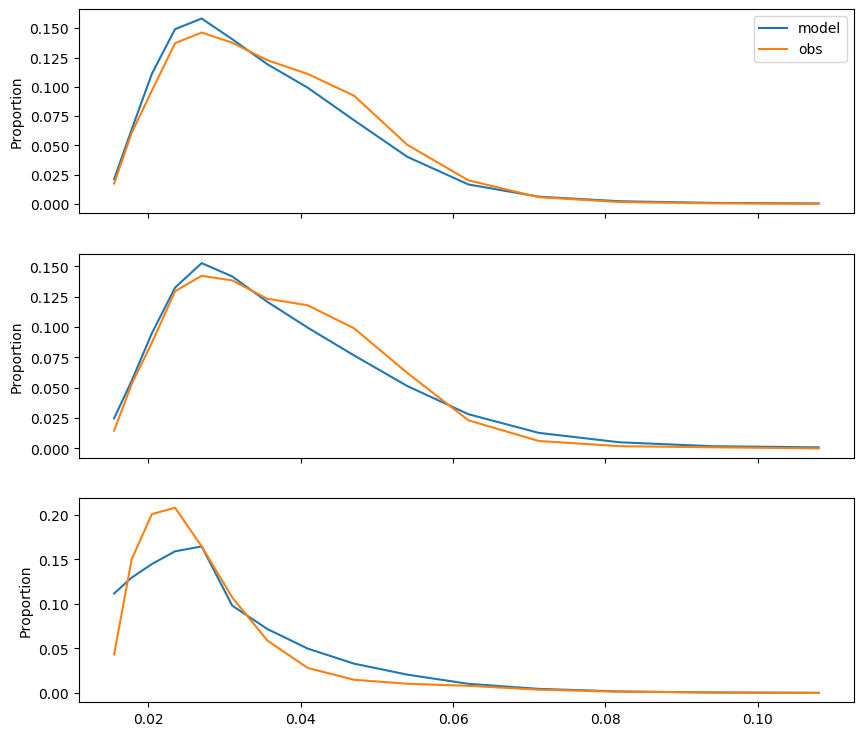

In [48]:
v_ext = data["v_min"] .* 2 .^(collect(1:1:data["m"]) .*delta_v) 
v_width = v_ext[2:end] .- v_ext[1:end-1]
fig,axs = plt.subplots(nrows=length(slice_indices), sharex=true, figsize=(10,length(slice_indices)*3))
for i in 1:length(slice_indices)
    axs[i].plot(v_ext,res["model"][:,slice_indices[i]],label = "model")
    axs[i].plot(v_ext,res["obs"][:,slice_indices[i]],label = "obs")
    axs[i].set_ylabel("Proportion")
end
axs[1].legend();